In [1]:
!pip install timesfm
!pip install git+https://github.com/DynaDojo/dynadojo

  Cloning https://github.com/DynaDojo/dynadojo to /tmp/pip-req-build-9ygffhxm
  Running command git clone --filter=blob:none --quiet https://github.com/DynaDojo/dynadojo /tmp/pip-req-build-9ygffhxm
  Resolved https://github.com/DynaDojo/dynadojo to commit a330ccb8e2a8f2b6481bf0aeac047ace3301bbc6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from dynadojo.systems.lorenz import LorenzSystem
from dynadojo.systems.lv import PreyPredatorSystem
from dynadojo.systems.lds import LDSystem
from dynadojo.systems.kuramoto import KuramotoSystem
from dynadojo.wrappers import SystemChecker, AlgorithmChecker
from dynadojo.utils.lds import plot

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

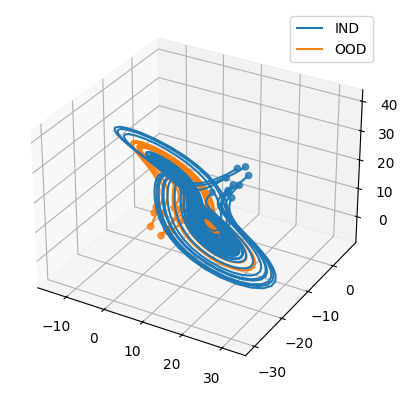

In [2]:
latent_dim = 3 # Number of variables
embed_dim = latent_dim
n = 50  # Number of trajectories in train set
test_size = 10  # Number of trajectories in test set
timesteps = 1000 # Timesteps in each trajectory
system = SystemChecker(LorenzSystem(latent_dim, embed_dim, noise_scale=0, seed=1912,
                                    sigma=10, r=28, a_squared=1/2.0, b=8.0/3.0,
                                    t_range=(0, 10),
                                    ))
# system = SystemChecker(LDSystem(latent_dim, embed_dim, noise_scale=0, seed=1912))
# system = SystemChecker(PreyPredatorSystem(latent_dim, embed_dim))
# system = SystemChecker(KuramotoSystem(embed_dim, embed_dim))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(test_size, in_dist=False)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps, noisy=False)
plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

In [3]:
from dynadojo.abstractions import AbstractAlgorithm
import timesfm
from typing import Any, Optional, List
import numpy as np
import enum

class TimesFMFrequency(enum.Enum):
  T = 0
  W = 1
  Q = 2

class TimesFMSingleton(object):
  def __new__(cls, context_len: int = 512, horizon_len: int = 128, backend: str = "gpu"):
    if not hasattr(cls, 'instance'):
      cls.instance = super(TimesFMSingleton, cls).__new__(cls)
      cls.instance.tfm = timesfm.TimesFm(
        context_len=context_len,
        horizon_len=horizon_len,
        input_patch_len=32, # Fixed for pretrained checkpoint.
        output_patch_len=128, # Fixed for pretrained checkpoint.
        num_layers=20, # Fixed for pretrained checkpoint.
        model_dims=1280, # Fixed for pretrained checkpoint.
        backend=backend)
      cls.instance.tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

    return cls.instance

  def forecast(self, x0seq: Any, freqs: List[TimesFMFrequency], **kwargs):
    return self.__class__.instance.tfm.forecast(x0seq, freq=[f.value for f in freqs])

2024-08-14 01:29:10.763371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [4]:
class TimesFMAlgorithmPretrained(AbstractAlgorithm):
  def __init__(self, embed_dim: int,
               timesteps: int,
               max_control_cost: float,
               seed: Optional[int] = None,
               context_len: int = 512,
               horizon_len: int = 128,
               backend: str = "gpu",
               freq: TimesFMFrequency = TimesFMFrequency.T,
               **kwargs):
    super().__init__(embed_dim, timesteps, max_control_cost, seed, **kwargs)
    # To handle the batch forecast case, support a horizon of embed_dim*horizon_len.
    self.tfm = TimesFMSingleton(context_len=context_len, horizon_len=embed_dim*horizon_len,backend=backend)
    self.freq = freq

  def fit(self, x: np.ndarray, **kwargs: Any) -> None:
    """
      No-op, since the foundation model is already pre-trained.

      Parameters
      ----------
      x : np.ndarray
          (n, timesteps, embed_dim) Trajectories tensor.
      **kwargs
          Additional keyword arguments.
    """
    # TODO consider use of fine-tuning API here: https://github.com/google-research/timesfm/blob/master/notebooks/finetuning.ipynb
    return None

  def predict(self, x0: np.ndarray, timesteps: int, **kwargs: Any) -> np.ndarray:
    """
    Predict how initial conditions matrix evolves over a given number of timesteps.

    Parameters
    ----------
    x0 : np.ndarray
        (n, embed_dim) initial conditions matrix - IGNORED
    timesteps : int
        timesteps per predicted trajectory
    x0seq : np.ndarray
        (n, init_timesteps, embed_dim) initial trajectories tensor
    forecast_batch: bool
        If true, predict the trajectory [(x0,y0,z0),(x1,y1,z1),...] by having the model forecast [x0,y0,z0,x1,y1,z1,...]
    **kwargs
        Additional keyword arguments.

    Returns
    -------
    np.ndarray
        (n, timesteps, embed_dim) trajectories tensor
    """
    x0seq=kwargs.get('x0seq', None) # (n, init_timesteps, embed_dim)
    forecast_batch=kwargs.get('forecast_batch', False)
    n, init_timesteps, embed_dim = x0seq.shape
    if not forecast_batch:
      # Perform univariate forecasting for each dimension of the trajectory.
      # This is likely to be inaccurate due to the model's lack of awareness of
      # correlations in each component of the trajectory
      x0seq_reshaped = x0seq.transpose(0, 2, 1).reshape((n*embed_dim, init_timesteps)) # (n*embed_dim, init_timesteps))
      freqs = [self.freq] * (n*embed_dim) # (n * embed_dim,)
      point_forecast, _ = self.tfm.forecast(x0seq_reshaped, freqs=freqs) # (n * embed_dim, embed_dim*horizon_len)
      return point_forecast[:, :timesteps].reshape((n, embed_dim, timesteps)).transpose(0, 2, 1) # (n, timesteps, embed_dim)
    else:
      # Reshape the trajectory [(x0,y0,z0),(x1,y1,z1),...] as [x0,y0,z0,x1,y1,z1,...] and feed this sequence to the foundation model.
      x0seq_reshaped = x0seq.reshape(n, init_timesteps*embed_dim) # (n, init_timesteps*embed_dim)
      freqs = [self.freq] * n
      point_forecast, _ = self.tfm.forecast(x0seq_reshaped, freqs=freqs) # (n, embed_dim*horizon_len)
      return point_forecast[:, :(embed_dim*timesteps)].reshape((n, timesteps, embed_dim)) # (n, timesteps, embed_dim)

In [5]:
for forecast_batch in (False, True):
  for freq in (TimesFMFrequency.T, TimesFMFrequency.W, TimesFMFrequency.Q):
    for leadin in (128, 256, 512):
      model = AlgorithmChecker(TimesFMAlgorithmPretrained(embed_dim, timesteps, max_control_cost=0, seed=42, freq=freq, context_len=512, horizon_len=1000))
      y_pred = model.predict(y0, timesteps-leadin, x0seq=y[:,:leadin,:],forecast_batch=forecast_batch)
      y_err = system.calc_error(y[:, leadin:, :], y_pred)
      print(f"{y_err=}")
      plot([y_pred, y[:, leadin:, :]], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15, title=f"{forecast_batch=},{freq=},{leadin=},{y_err=}")

RuntimeError: Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices. (you may need to uninstall the failing plugin package, or set JAX_PLATFORMS=cpu to skip this backend.)

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-08-14 01:31:02.929735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-14 01:31:02.929774: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
